In [4]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('hate_speech_dataset.csv')
df.head()

class                                              tweet
0      2  !!! RT @mayasolovely: As a woman you shouldn't...
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [6]:
df.shape

(24783, 2)

In [10]:
df.head()

class                                              tweet
0      2  !!! RT @mayasolovely: As a woman you shouldn't...
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


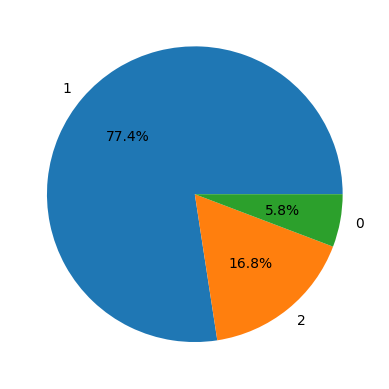

In [8]:
plt.pie(df['class'].value_counts().values,
		labels = df['class'].value_counts().index,
		autopct='%1.1f%%')
plt.show()

In [17]:
# Lower case all the words of the tweet before any preprocessing
df['tweet'] = df['tweet'].str.lower()

# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

class                                              tweet
0      2  rt mayasolovely woman shouldnt complain cleani...
1      1  rt mleew17 boy dats coldtyga dwn bad cuffin da...
2      1  rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3      1           rt cganderson vivabased look like tranny
4      1  rt shenikaroberts shit hear might true might f...

In [18]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():

		if word not in stop_words:

			# Let's Lemmatize the word as well
			# before appending to the imp_words list.

			lemmatizer = WordNetLemmatizer()
			lemmatizer.lemmatize(word)

			imp_words.append(word)

	output = " ".join(imp_words)

	return output


df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

class                                              tweet
0      2  rt mayasolovely woman shouldnt complain cleani...
1      1  rt mleew17 boy dats coldtyga dwn bad cuffin da...
2      1  rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3      1           rt cganderson vivabased look like tranny
4      1  rt shenikaroberts shit hear might true might f...

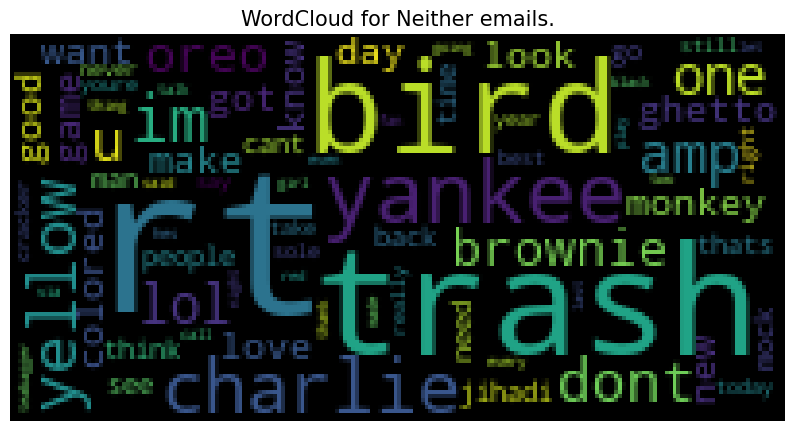

In [19]:
def plot_word_cloud(data, typ):
  # Joining all the tweets to get the corpus
  email_corpus = " ".join(data['tweet'])

  plt.figure(figsize = (10,10))

  # Forming the word cloud
  wc = WordCloud(max_words = 100,
                width = 200,
                height = 100,
                collocations = False).generate(email_corpus)

  # Plotting the wordcloud obtained above
  plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()

plot_word_cloud(df[df['class']==2], typ='Neither')

In [20]:
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500)
class_0 = df[df['class'] == 0]

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

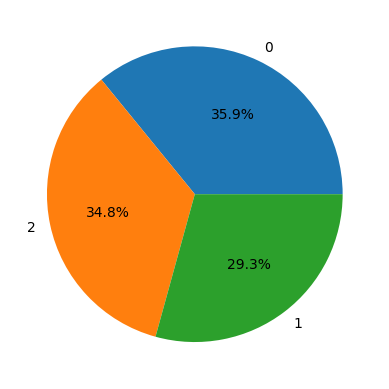

In [21]:
plt.pie(balanced_df['class'].value_counts().values,
		labels=balanced_df['class'].value_counts().index,
		autopct='%1.1f%%')
plt.show()

In [22]:
features = balanced_df['tweet']
target = balanced_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features,
												target,
												test_size=0.2,
												random_state=22)
X_train.shape, X_val.shape

((9562,), (2391,))

In [23]:
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_train.shape, Y_val.shape

((9562, 3), (2391, 3))

In [24]:
max_words = 5000
max_len = 100

token = Tokenizer(num_words=max_words,
				lower=True,
				split=' ')

token.fit_on_texts(X_train)

In [25]:
# training the tokenizer
max_words = 5000
token = Tokenizer(num_words=max_words,
				lower=True,
				split=' ')
token.fit_on_texts(X_train)

#Generating token embeddings
Training_seq = token.texts_to_sequences(X_train)
Training_pad = pad_sequences(Training_seq,
							maxlen=50,
							padding='post',
							truncating='post')

Testing_seq = token.texts_to_sequences(X_val)
Testing_pad = pad_sequences(Testing_seq,
							maxlen=50,
							padding='post',
							truncating='post')

In [43]:
model = keras.models.Sequential([
    keras.Input(shape=(max_len,)),
	layers.Embedding(max_words, 32, input_length=max_len),
	layers.Bidirectional(layers.LSTM(16)),
	layers.Dense(512, activation='relu', kernel_regularizer='l1'),
	layers.BatchNormalization(),
	layers.Dropout(0.3),
	layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
			optimizer='adam',
			metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,755 (729.51 KB)

 Trainable params: 185,731 (725.51 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [44]:
# Add a dummy input to build the model
model.build((None, max_len))

keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [45]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)

In [46]:
X_train

21627    value abu qutada8217s statement credentials ji...
16069    rt koolqueef color entire arm black sharpie fi...
18085    rt woodyafc maniac3x whiteponyjr lmaoooo bunch...
22430                                      walk hr yankees
3699     juanyeeze damn took dumb spic nearly 2 days re...
                               ...                        
15430    rt hypebeastaustin love one bucket headed hoes...
111        diamondloudkush fuck wrong bitches nobody knows
4593                 rylannwilliams ok chill love bird lol
21857                                call chief weak bitch
19686    rt minhazmerchant sonia never criticises kejri...
Name: tweet, Length: 9562, dtype: object

In [47]:
# Instantiate Tokenizer
tokenizer = Tokenizer(num_words=max_words)

# Fit on training data
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences for uniform length
from tensorflow.keras.utils import pad_sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len)

# Now use X_train_padded and X_val_padded in your model.fit()
history = model.fit(X_train_padded, Y_train,
					validation_data=(X_val_padded, Y_val),
					epochs=50,
					verbose=1,
					batch_size=32,
					callbacks=[lr, es])

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.6550 - loss: 3.8584 - val_accuracy: 0.4684 - val_loss: 1.0231 - learning_rate: 0.0010
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9014 - loss: 0.3830 - val_accuracy: 0.8160 - val_loss: 0.5540 - learning_rate: 0.0010
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9325 - loss: 0.2713 - val_accuracy: 0.8022 - val_loss: 0.6535 - learning_rate: 0.0010
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9497 - loss: 0.2172 - val_accuracy: 0.8729 - val_loss: 0.5195 - learning_rate: 0.0010
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9594 - loss: 0.1770 - val_accuracy: 0.8574 - val_loss: 0.5130 - learning_rate: 0.0010
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9712 - loss: 0.1520 - val_accuracy: 0.8561 - val_loss: 0.6438 - learning_rate: 0.0010
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9693 - loss: 0.

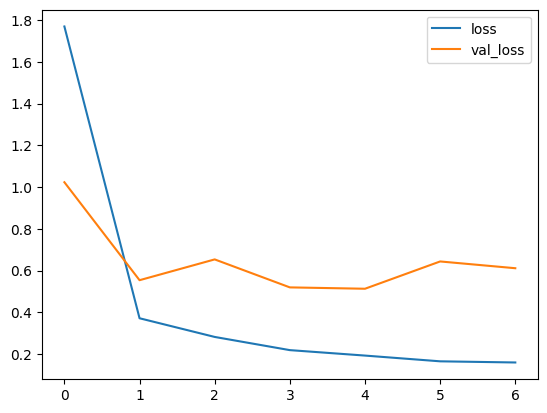

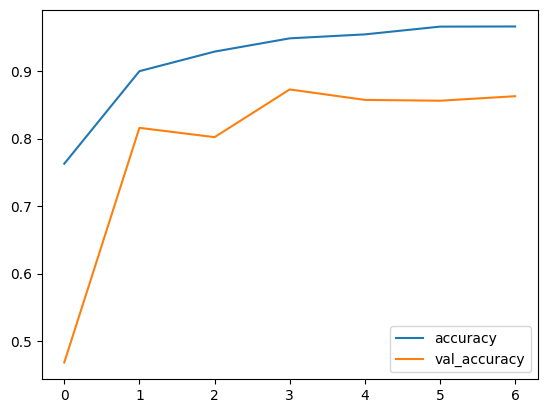

In [50]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [51]:
def predict_hate_speech(text):
    # Preprocess: tokenize and pad
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=100, padding='post', truncating='post')

    # Predict
    prediction = model.predict(padded)
    predicted_class = np.argmax(prediction)

    # Map to label
    label_map = {
        0: "Hate Speech",
        1: "Offensive Language",
        2: "Neither"
    }
    return label_map[predicted_class]

# Example usage
user_input = "fuck!" 
print("Prediction:", predict_hate_speech(user_input))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction: Neither


In [52]:
def predict_hate_speech(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=100, padding='post', truncating='post')
    prediction = model.predict(padded)
    print("Raw prediction:", prediction)
    predicted_class = np.argmax(prediction)

    label_map = {
        0: "Hate Speech",
        1: "Offensive Language",
        2: "Neither"
    }
    return label_map[predicted_class]

# Example usage
user_input = "nigger"
print("Prediction:", predict_hate_speech(user_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Raw prediction: [[0.00126102 0.02391791 0.97482115]]
Prediction: Neither


In [55]:
predicted = []
for twee in df['tweet']:
    predicted.append(predict_hate_speech(twee))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Raw prediction: [[0.0022199  0.04302265 0.95475745]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Raw prediction: [[0.00297581 0.05084    0.9461842 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Raw prediction: [[0.00177679 0.01541268 0.9828106 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Raw prediction: [[0.00168545 0.03784707 0.9604674 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Raw prediction: [[0.01367346 0.05625489 0.9300716 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Raw prediction: [[0.00142947 0.0166804  0.9818902 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Raw prediction: [[0.00139252 0.01860989 0.97999763]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Raw prediction: [[0.00196502 0.03462303 0.9634119 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Raw prediction: [[0.00395418 0.04879689 0.947249  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Raw prediction: [[0.00302598 0.05009897 0.946875  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Raw prediction: [[0.00155204 0.0319164  0.9665316 ]]